## Copy Python Files From Drive

In [331]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Imports')


from CRUMB import *
from fourier_model import *

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Imports

In [332]:
import os
import gc
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
import  matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [333]:
if not os.path.isdir("/content/gdrive/MyDrive/Colab Results"):
    os.mkdir("/content/gdrive/MyDrive/Colab Results")
if not os.path.isdir("/content/gdrive/MyDrive/Colab Results/at17_fourier_model"):
    os.mkdir("/content/gdrive/MyDrive/Colab Results/at17_fourier_model")

## Set Random Seed

In [334]:
list_of_seeds = [
    1327, 5208, 8208, 3515, 2710,
    4212, 1803, 3226, 2712, 7103,
    4310, 2808, 5916, 7600, 1522
]

random_seed = list_of_seeds[0]
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

## Data Handling

### Load Data

In [335]:

test_data = CRUMB('crumb', download=True, train=False, transform=None)
train_data = CRUMB('crumb', download=True, train=True, transform=None)

def count_labels(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

classes = train_data.classes

# Train data info
print("-------- Train Data --------")
print("Shape: ", train_data.data.shape)
for i in range(3):
    out = str(classes[i]) + ": " + str(count_labels(train_data.targets, i))
    print(out)
print("----------------------------")

# Test data info
print("\n-------- Test Data ---------")
print("Shape: ", test_data.data.shape)
for i in range(3):
    out = str(classes[i]) + ": " + str(count_labels(test_data.targets, i))
    print(out)
print("----------------------------")

-------- Train Data --------
Shape:  (1800, 150, 150, 1)
FRI: 863
FRII: 854
Hyb: 83
----------------------------

-------- Test Data ---------
Shape:  (300, 150, 150, 1)
FRI: 143
FRII: 143
Hyb: 14
----------------------------


### Isolate AT17 Data

In [336]:
at17_train_data = []
at17_train_labels = []
at17_test_data = []
at17_test_labels = []

for index in range(len(train_data.complete_labels)):
    label = train_data.complete_labels[index][2]
    if (label != -1):
        at17_train_labels.append(label)
        at17_train_data.append(train_data.data[index])

for index in range(len(test_data.complete_labels)):
    label = test_data.complete_labels[index][2]
    if (label != -1):
        at17_test_labels.append(label)
        at17_test_data.append(test_data.data[index])


In [337]:
x_train = np.array(at17_train_data)
x_test = np.array(at17_test_data)
y_train = np.array(at17_train_labels)
y_test = np.array(at17_test_labels)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(597, 150, 150, 1)
(597,)
(118, 150, 150, 1)
(118,)


### Split, augment, normalise, fft, and save

## Fourier Model

In [339]:
# from fourier_model import *
batch_size = 32
model = FourierModel(batch_size)

### Load and prepare data for training

In [340]:
# Load dataset
x_train_real = np.load("fft_data/x_train_real.npy")
x_train_imag = np.load("fft_data/x_train_imag.npy")
y_train = np.load("fft_data/y_train.npy")

x_valid_real = np.load("fft_data/x_valid_real.npy")
x_valid_imag = np.load("fft_data/x_valid_imag.npy")
y_valid = np.load("fft_data/y_valid.npy")

x_test_real = np.load("fft_data/x_test_real.npy")
x_test_imag = np.load("fft_data/x_test_imag.npy")
y_test = np.load("fft_data/y_test.npy")



# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_real, x_train_imag, y_train))
train_dataset = train_dataset.shuffle(n_train).batch(batch_size=batch_size)

# Prepare the testing dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_real, x_valid_imag, y_valid))
valid_dataset = valid_dataset.shuffle(n_valid).batch(batch_size=batch_size)

# Prepare the testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_real, x_test_imag, y_test))
test_dataset = test_dataset.shuffle(n_test).batch(batch_size=batch_size)

In [341]:
del x_train_fft_real
del x_train_fft_imag
del x_valid_fft_real
del x_valid_fft_imag
del x_test_fft_imag
del x_test_fft_real

gc.collect()

9820

### Metrics, optimizer

In [342]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
# OG l_r was 0.0001
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE) #- OG one


train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()


### Functions for custom loop

In [343]:

@tf.function
def compute_loss(labels, predictions):
      per_example_loss = loss_fn(labels, predictions)
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=batch_size)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        # loss_value = loss_fn(y, logits)
        loss_value = compute_loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    train_loss_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    val_loss_metric.update_state(y, val_logits)


### Run Training Loop

In [344]:
import time

# Lists to store training results
train_acc_logger = []
val_acc_logger = []
train_loss_logger = []
val_loss_logger = []

# To modify learning rate
val_loss_patience = 3
val_loss_wait = 0
best_val_loss = float('inf')


epochs = 20
for epoch in range(epochs):
    # if epoch > 5:
    #   optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.9)
    #   # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset
    for step, (x_batch_train_real, x_batch_train_imag, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step((x_batch_train_real, x_batch_train_imag), y_batch_train)

        # Log every 500 batches
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    train_acc_logger.append(train_acc)
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    train_loss = train_loss_metric.result()
    train_loss_logger.append(train_loss)
    print("Training loss over epoch: %.4f" % (float(train_loss),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()

    # Run validation loop at the end of each epoch
    for x_batch_val_real, x_batch_val_imag, y_batch_val in valid_dataset:
        test_step((x_batch_val_real, x_batch_val_imag), y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_logger.append(val_acc)

    val_loss = val_loss_metric.result()
    val_loss_logger.append(val_loss)

    val_acc_metric.reset_states()
    val_loss_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation loss: %.4f" % (float(val_loss),))
    print("Time taken: %.2f" % (time.time() - start_time))

    val_loss_wait += 1
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      val_loss_wait = 0
    if ((val_loss_wait >= val_loss_patience) and (epoch<epochs-2)):
      learning_rate = learning_rate * 0.1
      print("Learning rate decreased to: ", learning_rate)
      optimizer.learning_rate = learning_rate
      best_val_loss = val_loss
      val_loss_wait = 0



Start of epoch 0


Training loss (for one batch) at step 0: 1.1728
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.8410
Seen so far: 6432 samples


Training acc over epoch: 0.7596
Training loss over epoch: 0.6124
Validation acc: 0.7267
Validation loss: 1.0289
Time taken: 77.76

Start of epoch 1
Training loss (for one batch) at step 0: 0.9846
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.2459
Seen so far: 6432 samples
Training acc over epoch: 0.8072
Training loss over epoch: 0.4870
Validation acc: 0.8049
Validation loss: 0.6364
Time taken: 54.60

Start of epoch 2
Training loss (for one batch) at step 0: 0.3526
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.5787
Seen so far: 6432 samples
Training acc over epoch: 0.8340
Training loss over epoch: 0.4322
Validation acc: 0.8128
Validation loss: 0.7326
Time taken: 54.66

Start of epoch 3
Training loss (for one batch) at step 0: 0.2630
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.4818
Seen so far: 6432 samples
Training acc over epoch: 0.8417
Training loss over epoch: 0.4123
Validation acc: 0.8319
Validation loss: 0.5155


### Display Training Results

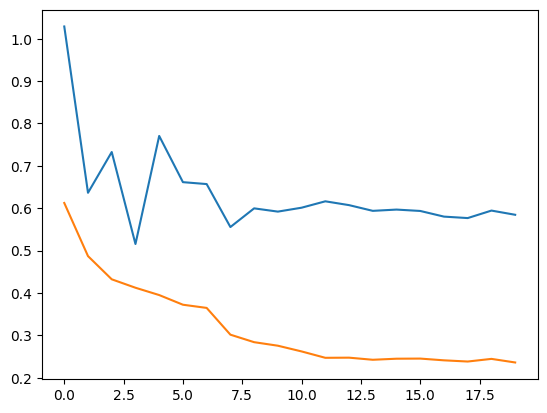

In [345]:
plt.plot(val_loss_logger)
plt.plot(train_loss_logger)

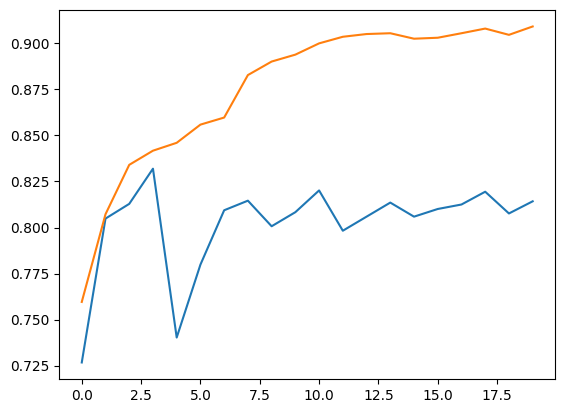

In [346]:
plt.plot(val_acc_logger)
plt.plot(train_acc_logger)

### Test Model

In [347]:
test_logits_list = []
y_actual_list = []
for x_batch_test_real, x_batch_test_imag, y_batch_test in test_dataset:
    test_logits = model((x_batch_test_real, x_batch_test_imag), training=False)
    y_actual_list.append(y_batch_test)
    test_logits_list.append(test_logits)

y_pred = []
for index in range(len(test_logits_list)):
    y_pred.append(tf.argmax(test_logits_list[index], axis=1))

y_pred = tf.concat(y_pred, axis=0)
y_actual = tf.concat(y_actual_list, axis=0)

In [348]:
overall_accuracy = accuracy_score(y_true=y_actual, y_pred=y_pred)
print("Overall Accuracy: ", overall_accuracy)

class_names = ['FRI', 'FRII', 'BENT']
report = classification_report(y_actual, y_pred, target_names=class_names)
print(report)

Overall Accuracy:  0.8471045197740112
              precision    recall  f1-score   support

         FRI       0.75      0.86      0.80       672
        FRII       0.87      0.87      0.87      1008
        BENT       0.90      0.82      0.85      1152

    accuracy                           0.85      2832
   macro avg       0.84      0.85      0.84      2832
weighted avg       0.85      0.85      0.85      2832



[[0.86458333 0.02380952 0.11160714]
 [0.09325397 0.87202381 0.03472222]
 [0.0859375  0.09895833 0.81510417]]
[0.86458333 0.87202381 0.81510417]
[1. 1. 1.]


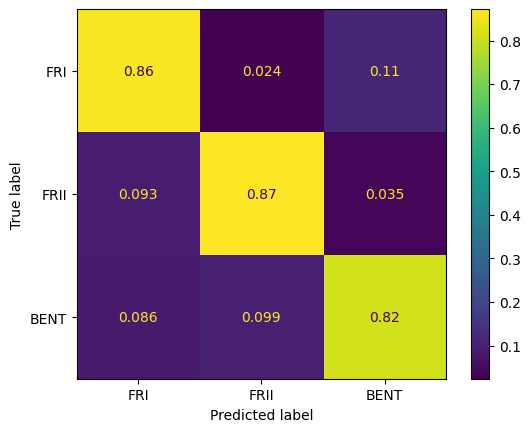

In [349]:
matrix = confusion_matrix(y_actual, y_pred, normalize='true')
print(matrix)
ConfusionMatrixDisplay(matrix, display_labels=class_names).plot()

print(matrix.diagonal()/matrix.sum(axis=1))
print(matrix.sum(axis=1))

[[581  16  75]
 [ 94 879  35]
 [ 99 114 939]]


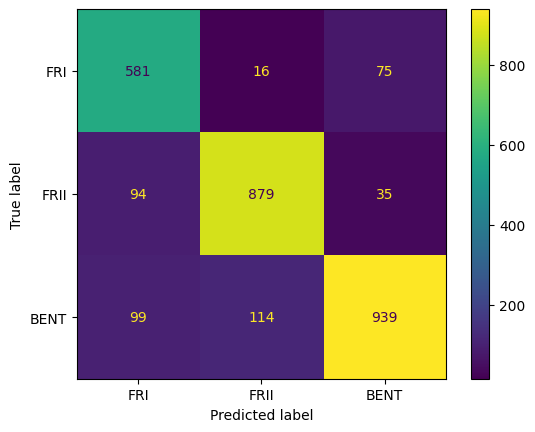

In [350]:
matrix = confusion_matrix(y_actual, y_pred)
print(matrix)
ConfusionMatrixDisplay(matrix, display_labels=class_names).plot()

### Save Results to Drive

In [351]:

directory = "/content/gdrive/MyDrive/Colab Results/at17_fourier_model/" + str(random_seed)

if not os.path.isdir(directory):
    os.mkdir(directory)

# Save results from training
np.save(directory + '/' + str(random_seed) + '_val_loss_logger.npy' , np.array(val_loss_logger))
np.save(directory + '/' + str(random_seed) + '_train_loss_logger.npy' , np.array(train_loss_logger))
np.save(directory + '/' + str(random_seed) + '_val_acc_logger.npy' , np.array(val_acc_logger))
np.save(directory + '/' + str(random_seed) + '_train_acc_logger.npy' , np.array(train_acc_logger))


# Save results from testing
y_pred_numpy = y_pred.numpy()
y_actual_numpy = y_actual.numpy()
file_name_pred = directory + '/' + str(random_seed) + "_y_pred.npy"
file_name_actual = directory + '/ '+ str(random_seed) + "_y_actual.npy"
np.save(file_name_pred, y_pred_numpy)
np.save(file_name_actual, y_actual_numpy)